In [55]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
%autoreload 2

In [57]:
from flows.model.model import FlowModel

from experiments.test_functions import u1, e1
import torch

In [58]:
import numpy as np
import torch
import random

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

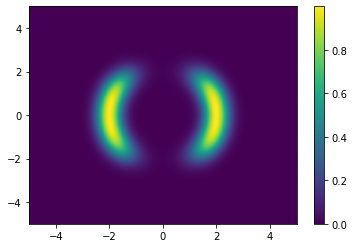

In [59]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kde
 
# create data
size = 5
 
nbins = 1000
xi, yi = np.mgrid[-size:size:nbins*1j, -size:size:nbins*1j]

wi = torch.Tensor(np.vstack([xi.flatten(), yi.flatten()])).T
# zi = u1()
zi = u1(wi).detach().numpy()
# Change color palette
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
plt.colorbar()
plt.show()

In [60]:
from flows.model.model import FlowModel
from flows.embedding.basic import Basic
from pyro.distributions.transforms import Planar

k = 2
dims = 2
embedding = Basic(dims) # .cuda()
transforms = list([Planar(dims) for i in range(0,k)])

model = FlowModel(
    embedding=embedding,
    transforms=transforms
)
# model = model.cuda()

In [61]:
model(torch.tensor([1,1])).sample()

tensor([[-0.7627, -0.8911],
        [ 0.2588,  0.5117]])

In [62]:
from flows.loss.elbo import FlowELBO
from tqdm.notebook import tqdm
from pyro.optim import SGD
from pyro.contrib.autoguide import AutoContinuous
from pyro.infer.trace_elbo import Trace_ELBO
from pyro.infer.svi import SVI

batch_size = 64
args = {}


In [63]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00001, momentum=0.9)


In [64]:
NUM_PARAMETERS = sum(p.numel() for p in model.parameters())
print("Number of parameters:", NUM_PARAMETERS)

Number of parameters: 16


  0%|          | 0/31250 [00:00<?, ?it/s]

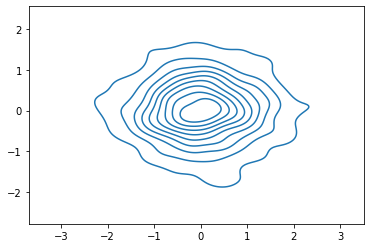

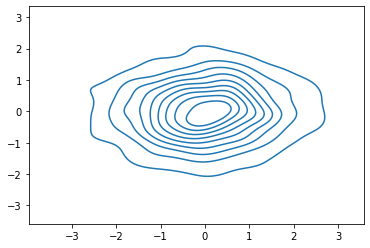

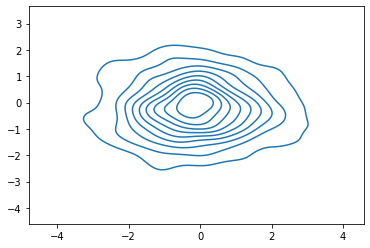

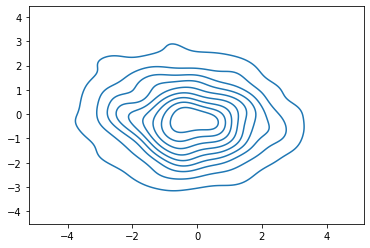

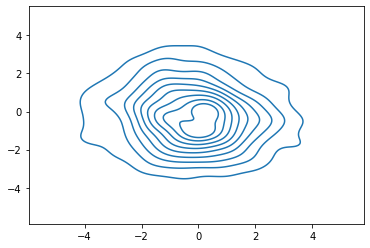

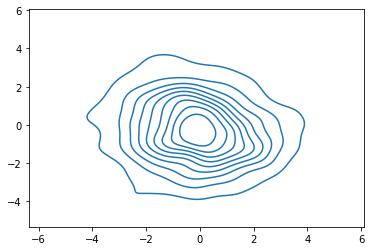

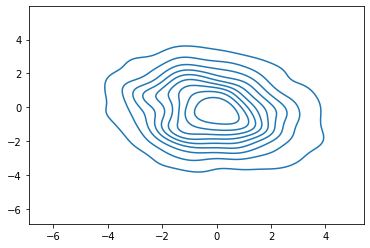

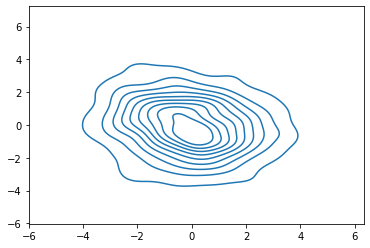

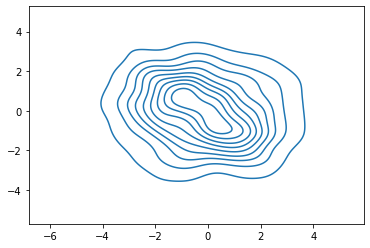

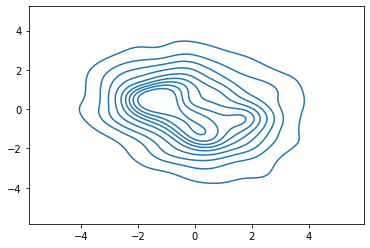

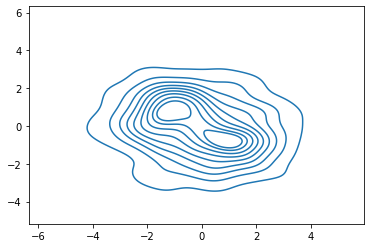

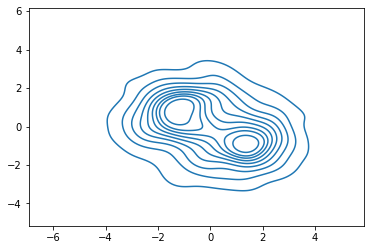

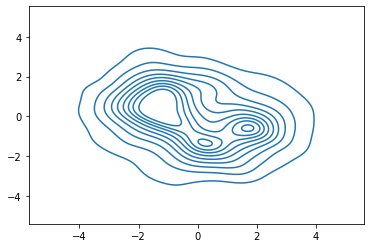

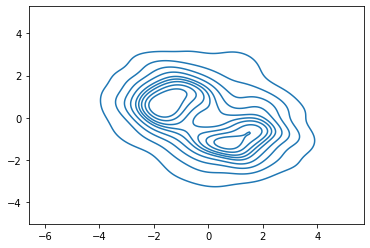

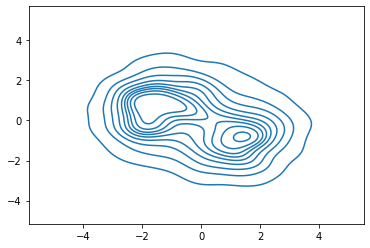

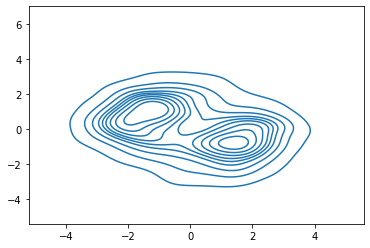

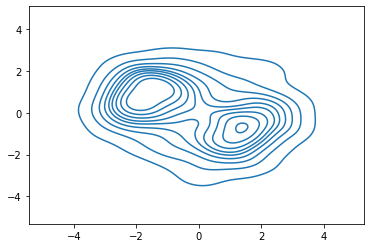

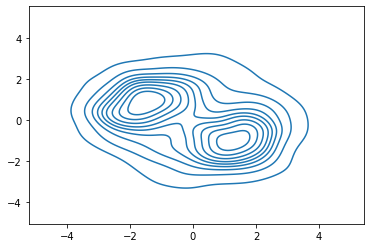

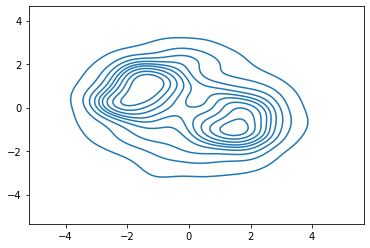

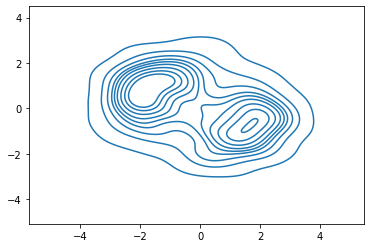

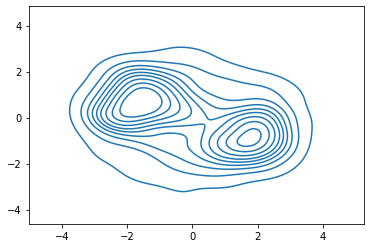

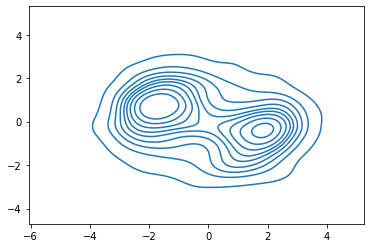

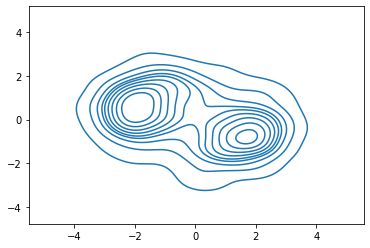

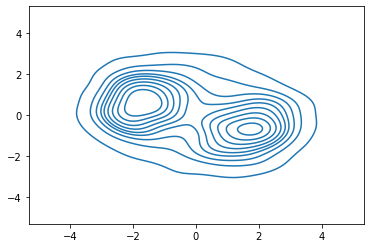

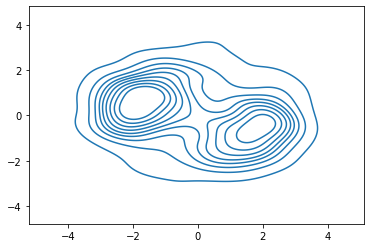

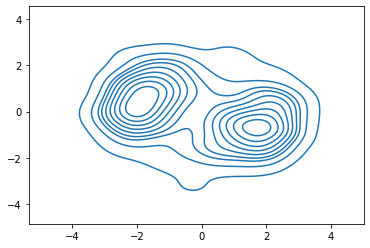

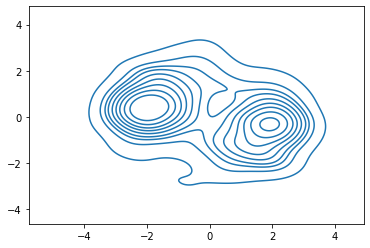

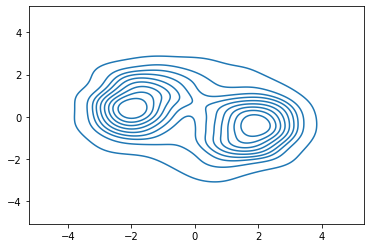

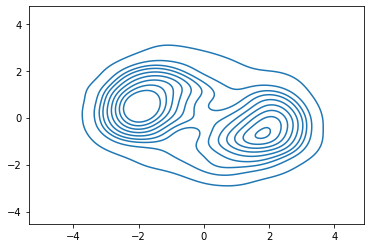

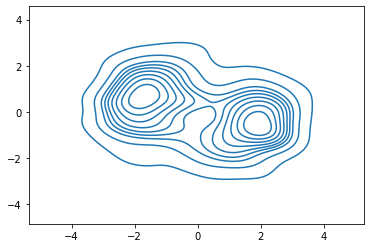

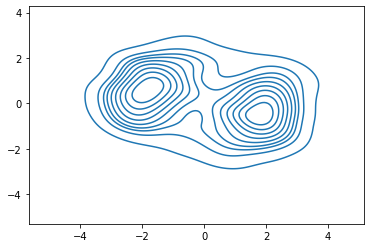

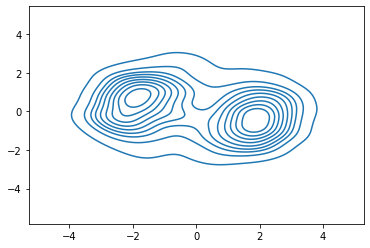

In [65]:

import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(f"runs/planar_flow_seed={SEED}")

NUM_STEPS = int(np.ceil(500000 / NUM_PARAMETERS))
pbar = tqdm(range(NUM_STEPS))
input_tensor = torch.ones((100, 1))
torch.autograd.set_detect_anomaly(False)


for step in pbar:
    optimizer.zero_grad()
    loss = FlowELBO(e1, model(input_tensor), num_samples=1, epoch=step)
    pbar.set_postfix_str("loss: " + '{0:.2f}'.format(loss.item()))
    loss.backward()
    optimizer.step()
    # writer.add_scalar("embedding_covariance_determinant", torch.det(model.embedding.cov).item(), step * NUM_PARAMETERS)
    # writer.add_scalar("embedding_mean_magnitude", torch.norm(torch.abs(model.embedding.mean)).item(), step * NUM_PARAMETERS)
    writer.add_scalar("_loss", loss.item(), step * NUM_PARAMETERS)
    if step % 1000 == 0:
        samples = model(torch.tensor([[1]])).sample((1000,)).detach()
        sns.kdeplot(x=samples[:,0, 0].detach().cpu().numpy(), y=samples[:,0, 1].detach().cpu().numpy())
        plt.show()
    # print("{: >5d}\t{}".format(step, loss ))

In [69]:
loss = FlowELBO(e1, model(input_tensor), num_samples=10000, epoch=10000)
print(loss.item())

-0.9344192743301392


In [67]:
list(model.named_parameters())

[('embedding.mean',
  Parameter containing:
  tensor([-0.0104, -0.0058], requires_grad=True)),
 ('embedding.L',
  Parameter containing:
  tensor([[0.6063, 0.0000],
          [0.3752, 0.8752]], requires_grad=True)),
 ('transforms.0.bias',
  Parameter containing:
  tensor([0.0716], requires_grad=True)),
 ('transforms.0.u',
  Parameter containing:
  tensor([-1.3342, -0.3917], requires_grad=True)),
 ('transforms.0.w',
  Parameter containing:
  tensor([-2.8667, -0.1362], requires_grad=True)),
 ('transforms.1.bias',
  Parameter containing:
  tensor([0.0237], requires_grad=True)),
 ('transforms.1.u',
  Parameter containing:
  tensor([-0.8288,  1.1991], requires_grad=True)),
 ('transforms.1.w',
  Parameter containing:
  tensor([-2.7193,  1.3052], requires_grad=True))]

In [68]:
# we can't just call log_prob on an artbitary vector
# since it doesn't have a anlytic solution
# and uses cache to compute the log_prob

samples = model(torch.tensor([[1]])).sample((1000,))
log_probs = model(torch.tensor([[1]])).log_prob(samples).detach().numpy()
probs = np.exp(log_probs)
xs = samples[:,0].detach().numpy()
ys = samples[:,1].detach().numpy()
plt.scatter(xs,ys, c=probs.reshape(xs.shape), cmap='turbo', marker='.')
plt.colorbar()
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.show()

IndexError: index 1 is out of bounds for dimension 1 with size 1